In [1]:
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.show()

+-------+----------+---------+---------+-------+------------+-------+-------------+------------+----------+-------------------------+----------------------+----------------------+---------+-----------+-----+---+---+----+----------+-------------------+------+-------+------+--------------------+---------+------------+-------+---------+-----------+--------+--------+-----------+-----------+-------------+---------+-----------------+------------+-------+-----------------+-------------+------------------+---------------------+-----------------------+-----------------------+-------+------------+-------+--------------------------+--------------------------+----------------+----------------+-------------+-------------+------------------+------------------+------------------+-----------------------+------------+---------------+---------------+------------------+--------------------+-----------------+---------------------+------------------+---------------+---------+------------+------------------

In [2]:
play_type_distribution = df.groupBy("play_type").count().show()

+--------------------+------+
|           play_type| count|
+--------------------+------+
|          field_goal| 10819|
|                None| 14473|
| Shotgun) C.Keenu...|     1|
|             no_play| 47225|
|         False Start|     1|
|         extra_point| 12209|
|             kickoff| 28326|
|            qb_kneel|  4271|
|                 run|146702|
|                punt| 26260|
| Shotgun) J.Allen...|     1|
|            qb_spike|   762|
|                pass|207184|
+--------------------+------+



In [3]:
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass', 'qb_kneel', 'qb_spike']
df = df.filter(df.play_type.isin(offensive_playtypes))
df.groupBy("play_type").count().show()

+----------+------+
| play_type| count|
+----------+------+
|field_goal| 10819|
|  qb_kneel|  4271|
|       run|146702|
|      punt| 26260|
|  qb_spike|   762|
|      pass|207184|
+----------+------+



In [4]:
from pyspark.sql.functions import year, col, when
from pyspark.sql import functions as F

play_type_vs_quarter = df.groupBy("qtr", "play_type").count().orderBy("qtr", ascending=False).show(1000)  
play_type_vs_down = df.groupBy("down", "play_type").count().orderBy("down", ascending=False).show(1000)
play_type_home_away = df.groupBy("posteam_type", "play_type").count().orderBy("posteam_type", ascending=False).show(1000)
play_type_vs_formation = df.groupBy("shotgun", "play_type").count().orderBy("shotgun", ascending=False).show(1000)
play_type_year_distribution = df.groupBy(year(col("game_date")).alias("year"), "play_type").count().orderBy("year", ascending=False).show(1000)


play_type_vs_field_position = df.groupBy(
    F.when((df["yardline_100"] >= 1) & (df["yardline_100"] <= 20), "1-20")
     .when((df["yardline_100"] >= 21) & (df["yardline_100"] <= 40), "21-40")
     .when((df["yardline_100"] >= 41) & (df["yardline_100"] <= 60), "41-60")
     .when((df["yardline_100"] >= 61) & (df["yardline_100"] <= 80), "61-80")
     .when((df["yardline_100"] >= 81) & (df["yardline_100"] <= 99), "81-99")
     .otherwise("Out of Range").alias("field_position_range"),  
    "play_type"
).count().orderBy("field_position_range").show(1000)

play_type_vs_score = df.groupBy(
    F.when((df["score_differential_post"] == 0), "0")
     .when((df["score_differential_post"] >= 3) & (df["score_differential_post"] <= 8), "3-8")
     .when((df["score_differential_post"] >= 9) & (df["score_differential_post"] <= 14), "9-14")
     .when((df["score_differential_post"] >= 15) & (df["score_differential_post"] <= 20), "15-20")
     .when((df["score_differential_post"] >= 21) & (df["score_differential_post"] <= 26), "21-26")
     .when((df["score_differential_post"] >= 27) & (df["score_differential_post"] <= 32), "27-32")
     .when((df["score_differential_post"] >= 33), "33+")
     .when((df["score_differential_post"] <= -3) & (df["score_differential_post"] >= -8), "-3 to -8")
     .when((df["score_differential_post"] <= -9) & (df["score_differential_post"] >= -14), "-9 to -14")
     .when((df["score_differential_post"] <= -15) & (df["score_differential_post"] >= -20), "-15 to -20")
     .when((df["score_differential_post"] <= -21) & (df["score_differential_post"] >= -26), "-21 to -26")
     .when((df["score_differential_post"] <= -27) & (df["score_differential_post"] >= -32), "-27 to -32")
     .when((df["score_differential_post"] <= -33), "-33 or lower")
     .otherwise("Out of Range").alias("score_differential_range"),  # Apply directly in groupBy
    "play_type"
).count().orderBy("score_differential_range").show(1000)

+---+----------+-----+
|qtr| play_type|count|
+---+----------+-----+
|  5|      pass| 1339|
|  5|  qb_spike|   11|
|  5|       run| 1086|
|  5|      punt|  166|
|  5|field_goal|  164|
|  5|  qb_kneel|   12|
|  4|      punt| 6130|
|  4|       run|36902|
|  4|field_goal| 2789|
|  4|      pass|57526|
|  4|  qb_kneel| 3291|
|  4|  qb_spike|  418|
|  3|field_goal| 2031|
|  3|       run|35827|
|  3|      pass|45920|
|  3|      punt| 6180|
|  3|  qb_kneel|   25|
|  2|  qb_spike|  333|
|  2|field_goal| 3835|
|  2|       run|35736|
|  2|  qb_kneel|  917|
|  2|      punt| 7259|
|  2|      pass|58675|
|  1|field_goal| 2000|
|  1|      pass|43724|
|  1|      punt| 6525|
|  1|       run|37151|
|  1|  qb_kneel|   26|
+---+----------+-----+

+----+----------+-----+
|down| play_type|count|
+----+----------+-----+
| 4.0|field_goal| 9942|
| 4.0|      punt|26258|
| 4.0|      pass| 3419|
| 4.0|  qb_kneel|   33|
| 4.0|       run| 1936|
| 3.0|  qb_spike|   52|
| 3.0|field_goal|  275|
| 3.0|  qb_kneel|  587|

In [5]:
play_type_vs_quarter_df = df.groupBy("qtr", "play_type").count().orderBy("qtr", ascending=False).toPandas()
play_type_vs_down_df = df.groupBy("down", "play_type").count().orderBy("down", ascending=False).toPandas()
play_type_home_away_df = df.groupBy("posteam_type", "play_type").count().orderBy("posteam_type", ascending=False).toPandas()
play_type_vs_formation_df = df.groupBy("shotgun", "play_type").count().orderBy("shotgun", ascending=False).toPandas()
play_type_year_distribution_df = df.groupBy(year(col("game_date")).alias("year"), "play_type").count().orderBy("year", ascending=False).toPandas()
play_type_vs_field_position_df = play_type_vs_field_position = df.groupBy(
    F.when((df["yardline_100"] >= 1) & (df["yardline_100"] <= 20), "1-20")
     .when((df["yardline_100"] >= 21) & (df["yardline_100"] <= 40), "21-40")
     .when((df["yardline_100"] >= 41) & (df["yardline_100"] <= 60), "41-60")
     .when((df["yardline_100"] >= 61) & (df["yardline_100"] <= 80), "61-80")
     .when((df["yardline_100"] >= 81) & (df["yardline_100"] <= 99), "81-99")
     .otherwise("Out of Range").alias("field_position_range"),  
    "play_type"
).count().orderBy("field_position_range").toPandas()

play_type_vs_score_df = df.groupBy(
    F.when((df["score_differential_post"] == 0), "0")
     .when((df["score_differential_post"] >= 3) & (df["score_differential_post"] <= 8), "3-8")
     .when((df["score_differential_post"] >= 9) & (df["score_differential_post"] <= 14), "9-14")
     .when((df["score_differential_post"] >= 15) & (df["score_differential_post"] <= 20), "15-20")
     .when((df["score_differential_post"] >= 21) & (df["score_differential_post"] <= 26), "21-26")
     .when((df["score_differential_post"] >= 27) & (df["score_differential_post"] <= 32), "27-32")
     .when((df["score_differential_post"] >= 33), "33+")
     .when((df["score_differential_post"] <= -3) & (df["score_differential_post"] >= -8), "-3 to -8")
     .when((df["score_differential_post"] <= -9) & (df["score_differential_post"] >= -14), "-9 to -14")
     .when((df["score_differential_post"] <= -15) & (df["score_differential_post"] >= -20), "-15 to -20")
     .when((df["score_differential_post"] <= -21) & (df["score_differential_post"] >= -26), "-21 to -26")
     .when((df["score_differential_post"] <= -27) & (df["score_differential_post"] >= -32), "-27 to -32")
     .when((df["score_differential_post"] <= -33), "-33 or lower")
     .otherwise("Out of Range").alias("score_differential_range"),  
    "play_type"
).count().toPandas()

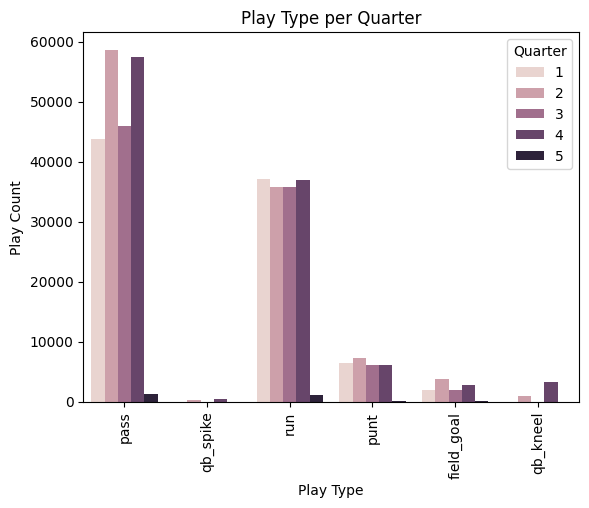

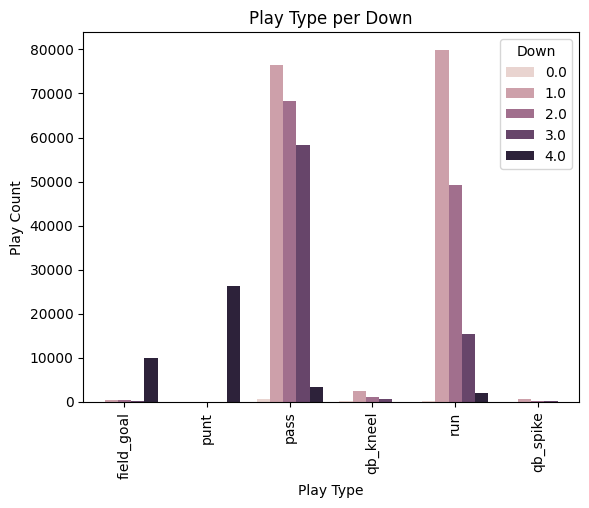

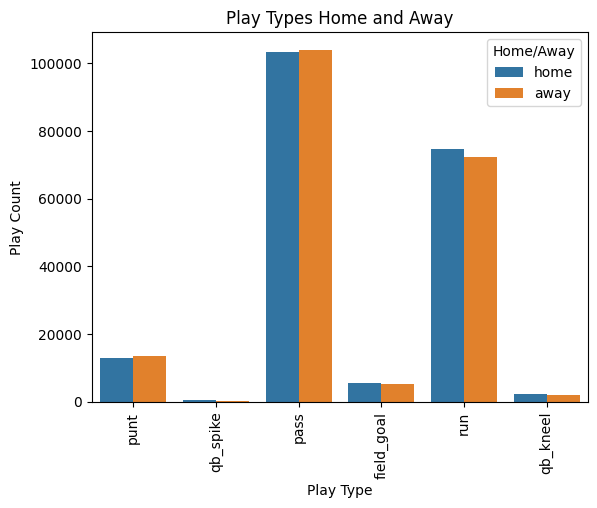

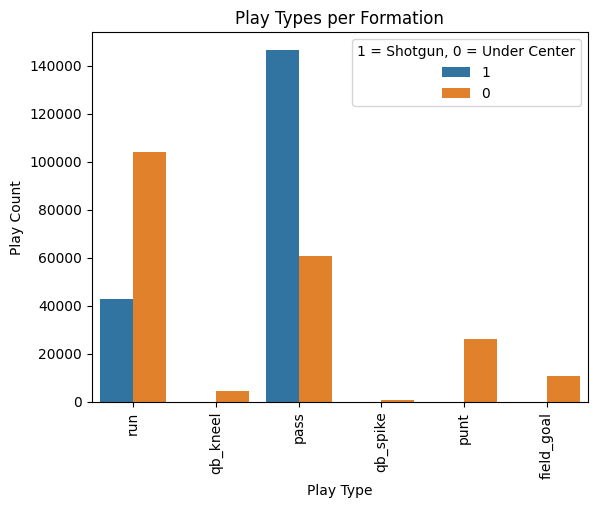

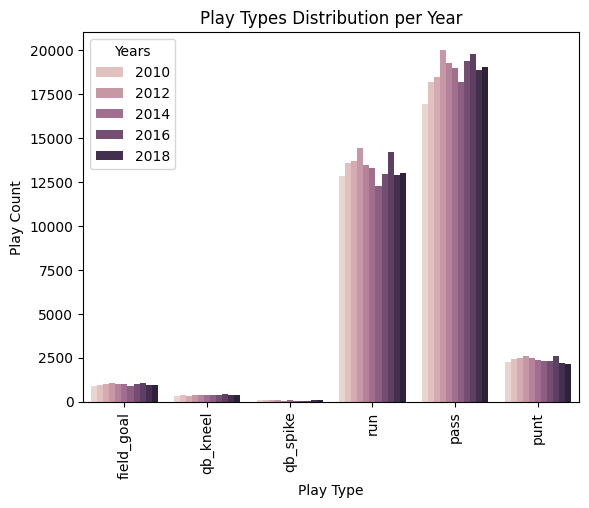

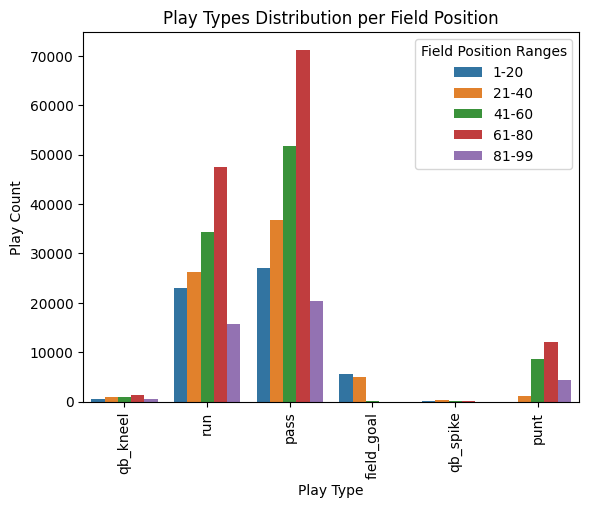

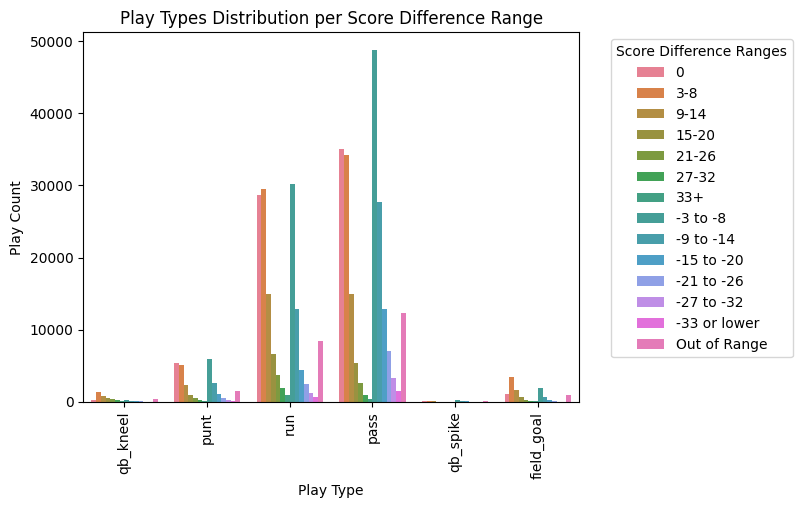

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x='play_type', y='count', hue='qtr', data=play_type_vs_quarter_df)
plt.title("Play Type per Quarter")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="Quarter")  
plt.show()


sns.barplot(x='play_type', y='count', hue='down', data=play_type_vs_down_df)
plt.title("Play Type per Down")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="Down")  
plt.show()

sns.barplot(x='play_type', y='count', hue='posteam_type', data=play_type_home_away_df)
plt.title("Play Types Home and Away")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="Home/Away")  
plt.show()

sns.barplot(x='play_type', y='count', hue='shotgun', data=play_type_vs_formation_df)
plt.title("Play Types per Formation")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="1 = Shotgun, 0 = Under Center")  
plt.show()

sns.barplot(x='play_type', y='count', hue='year', data=play_type_year_distribution_df)
plt.title("Play Types Distribution per Year")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="Years")  
plt.show()

sns.barplot(x='play_type', y='count', hue='field_position_range', data=play_type_vs_field_position_df)
plt.title("Play Types Distribution per Field Position")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="Field Position Ranges")  
plt.show()

# Define the desired order for the hue (score difference ranges)
score_range_order = [
    "0", "3-8", "9-14", "15-20", "21-26", "27-32", "33+",
    "-3 to -8", "-9 to -14", "-15 to -20", "-21 to -26", "-27 to -32", "-33 or lower", "Out of Range"
]

# Now plot the bar plot with the specific hue order
sns.barplot(x='play_type', y='count', hue='score_differential_range', data=play_type_vs_score_df, hue_order=score_range_order)
plt.title("Play Types Distribution per Score Difference Range")
plt.xlabel("Play Type")
plt.ylabel("Play Count")
plt.xticks(rotation=90)  
plt.legend(title="Score Difference Ranges", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

In [7]:

columns_to_drop = [
    'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
    'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result',
    'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 
    'timeout_team', 'td_team', 'total_home_score', 'total_away_score', 'posteam_score',
    'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post',
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty',
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed',
    'incomplete_pass', 'touchback', 'interception', 'punt_inside_twenty', 'punt_in_endzone',
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty',
    'kickoff_in_endzone', 'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety',
    'penalty', 'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td',
    'qb_hit', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown',
    'extra_point_attempt', 'two_point_attempt', 'kickoff_attempt', 'fumble', 'assist_tackle',
    'lateral_reception', 'lateral_rush', 'lateral_return', 'lateral_recovery', 'return_team',
    'return_yards', 'penalty_team', 'penalty_yards', 'replay_or_challenge', 'replay_or_challenge_result',
    'penalty_type', 'defensive_two_point_attempt', 'defensive_two_point_conv',
    'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'quarter_seconds_remaining', 
    'half_seconds_remaining', 'quarter_end', 'time', 'desc', 'qb_dropback', 'defteam',
    'yrdln', 'ydsnet', 'side_of_field', 'game_half', 'sp', 'complete_pass', 'drive'
]


df = df[[col for col in df.columns if col not in columns_to_drop]]
columns = df.columns
print("Columns in the DataFrame:", columns)

Columns in the DataFrame: ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'yardline_100', 'game_date', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_kneel', 'qb_spike', 'timeout', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'score_differential_post', 'rush_attempt', 'pass_attempt', 'field_goal_attempt', 'punt_attempt']


In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

categorical_columns = ['play_type', 'home_team', 'away_team', 'posteam', 'posteam_type']

indexers = [StringIndexer(inputCol=col, outputCol=col + '_index') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + '_index', outputCol=col + '_encoded') for col in categorical_columns]

pipeline = Pipeline(stages=indexers + encoders)

model = pipeline.fit(df)
df_encoded = model.transform(df)
df_encoded.select([col + '_encoded' for col in categorical_columns]).show(10)

+-----------------+-----------------+-----------------+---------------+--------------------+
|play_type_encoded|home_team_encoded|away_team_encoded|posteam_encoded|posteam_type_encoded|
+-----------------+-----------------+-----------------+---------------+--------------------+
|    (5,[1],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[12],[1.0])|           (1,[],[])|
|    (5,[0],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[12],[1.0])|           (1,[],[])|
|    (5,[0],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[12],[1.0])|           (1,[],[])|
|    (5,[2],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[12],[1.0])|           (1,[],[])|
|    (5,[1],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[27],[1.0])|       (1,[0],[1.0])|
|    (5,[0],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[27],[1.0])|       (1,[0],[1.0])|
|    (5,[1],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[27],[1.0])|       (1,[0],[1.0])|
|    (5,[0],[1.0])|  (34,[28],[1.0])|  (34,[26],[1.0])|(34,[27],[1.0])

In [9]:
from pyspark.sql.window import Window

df_encoded = df_encoded.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)  
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')

df_encoded = df_encoded.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df_encoded = df_encoded.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df_encoded = df_encoded.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df_encoded = df_encoded.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df_encoded = df_encoded.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df_encoded = df_encoded.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df_encoded = df_encoded.withColumn('posteam_leading', col('score_differential_post') > 0)
df_encoded = df_encoded.withColumn('posteam_trailing', col('score_differential_post') < 0)


In [10]:
print(df_encoded.columns)
df_encoded.head(50)

['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'yardline_100', 'game_date', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_kneel', 'qb_spike', 'timeout', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'score_differential_post', 'rush_attempt', 'pass_attempt', 'field_goal_attempt', 'punt_attempt', 'play_type_index', 'home_team_index', 'away_team_index', 'posteam_index', 'posteam_type_index', 'play_type_encoded', 'home_team_encoded', 'away_team_encoded', 'posteam_encoded', 'posteam_type_encoded', 'play_success', 'cumulative_rush_attempts', 'cumulative_pass_attempts', 'cumulative_rush_successes', 'cumulative_pass_successes', 'rush_success_rate', 'pass_success_rate', 'posteam_leading', 'posteam_trailing']


[Row(play_id=375, game_id=2009091310, home_team='NYG', away_team='WAS', posteam='WAS', posteam_type='away', yardline_100=71.0, game_date=datetime.date(2009, 9, 13), game_seconds_remaining=3152.0, qtr=1, down=1.0, goal_to_go=0.0, ydstogo=10, play_type='run', yards_gained='34.0', shotgun='0', no_huddle='0', qb_kneel=0.0, qb_spike=0, timeout='0.0', posteam_timeouts_remaining='3.0', defteam_timeouts_remaining='2.0', score_differential_post=-3.0, rush_attempt=1.0, pass_attempt=0.0, field_goal_attempt=0.0, punt_attempt=0.0, play_type_index=1.0, home_team_index=4.0, away_team_index=19.0, posteam_index=24.0, posteam_type_index=1.0, play_type_encoded=SparseVector(5, {1: 1.0}), home_team_encoded=SparseVector(34, {4: 1.0}), away_team_encoded=SparseVector(34, {19: 1.0}), posteam_encoded=SparseVector(34, {24: 1.0}), posteam_type_encoded=SparseVector(1, {}), play_success=1, cumulative_rush_attempts=1, cumulative_pass_attempts=0, cumulative_rush_successes=1, cumulative_pass_successes=0, rush_success_

In [11]:
df_encoded_cleaned = df_encoded.drop(*[
    'home_team', 'away_team', 'posteam', 'posteam_type', 'play_type',
    'home_team_index', 'away_team_index', 'posteam_index', 'posteam_type_index'
])

print(df_encoded_cleaned.columns)

df_pandas = df_encoded_cleaned.toPandas()

df_pandas.to_csv('NFL_PBP_V2.csv', index=False)

['play_id', 'game_id', 'yardline_100', 'game_date', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'yards_gained', 'shotgun', 'no_huddle', 'qb_kneel', 'qb_spike', 'timeout', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'score_differential_post', 'rush_attempt', 'pass_attempt', 'field_goal_attempt', 'punt_attempt', 'play_type_index', 'play_type_encoded', 'home_team_encoded', 'away_team_encoded', 'posteam_encoded', 'posteam_type_encoded', 'play_success', 'cumulative_rush_attempts', 'cumulative_pass_attempts', 'cumulative_rush_successes', 'cumulative_pass_successes', 'rush_success_rate', 'pass_success_rate', 'posteam_leading', 'posteam_trailing']


Completed:
1)Cleaned Play type options, were a couple weird ones that must have been mistakes with only 1 count
2)Selected all Offensive play types to inspect and work with
3)Summarized/Counted/Visualized Play Distribution for many cases
4)Removed many more useless features: Result features (which way run or pass was, failed or completed attempts, touchdown), all defensive and special team categories, penalty categories). Chose these as we are only focusing on predicting the offenses next play type so these do nothing for us, most important variables should be score difference, quarter, yards to go (yards to first down), yrdline-100(position on field as a whole), seconds remaining, shotgun (binary formation category) from the original dataset. 
5)One Hot Encoding to transform categorical features to numerical: Play_type, home_team, away_team, posteam, and posteam_type
6)Feature Engineering: Trailing/leading boolean categories, recent pass and run plays success rate
7)Dropped features that are now One Hot Encoded features, Saved Data to new CSV file version

Plan Next Week:
1)Correlation Analysis, PCA
2)Split Data for train test validation
3)Training the model. Multi-Class classification, want to train Gradient Boosted Tree from SparkMLib. Seems like a good fit and havent worked with one before. 

Project Proposal Schedule:
• Week 1: Research and Planning ************Complete
• Week 2: Hadoop/Spark setup for data ingestion pipeline ***********Complete
• Week 3: Data Cleaning, Pre-Processing, and Feature Engineering *************Complete
• Week 4: Training of Machine Learning Model 
• Week 5: Model optimization  
• Week 6: Build some type of visualization dashboard 
• Week 7: Analysis and Evaluation 
• Week 8: Report and Presentation
